In [1]:
import sqlite3
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

log_file = "log_file.txt"
csv_file = 'transformed_data.csv'

conn = sqlite3.connect('sahibinden_rent.db')
table_name = 'RENT_HOUSE'

In [2]:
def extract_from_csv(file_to_process):
    """Reads a CSV file and returns it as a pandas DataFrame."""
    dataframe = pd.read_csv(file_to_process)
    return dataframe

def extract():
    """Extracts data from multiple CSV files in the current directory and combines them into a single DataFrame."""
    extracted_data = pd.DataFrame(columns=['title','area','numberOfRooms','price','town','district'])

    for csvfile in glob.glob('*.csv'):
        extracted_data = pd.concat([extracted_data, pd.DataFrame(extract_from_csv(csvfile))], ignore_index=True)

    return extracted_data

In [3]:
def transform(data):
    """It does only the necessary transformation on the data."""
    del data['Unnamed: 0']
    data['town'] = data['town'].astype(str)
    data['numberOfRooms'] = data['numberOfRooms'].astype(str)

    try:
        data['price'] = pd.to_numeric(data['price'], errors='raise')
        data['area'] = data['area'].astype(int)
    except ValueError:
        print('Value Error')
    
    return data

In [4]:
def load_data(csv_file, table_name, conn, transformed_data):
    """Loads the data to csv format and db format."""
    transformed_data.to_csv(csv_file)
    transformed_data.to_sql(table_name, conn, if_exists='replace', index=False)

In [5]:
def log_progress(message):
    """Logs the progress message along with a timestamp to a log file."""
    timestamp_format = '%Y-%h-%d-%H:%M:%S'
    now = datetime.now()
    timestamp = now.strftime(timestamp_format)
    with open(log_file, "a") as f:
        f.write(timestamp + '' + message + '\n')

In [6]:
log_progress("ETL JOB STARTED")

log_progress("EXTRACT PHASE STARTED")
extracted_data = extract()
log_progress("EXTRACT PHASE ENDED")

log_progress("TRANSFORM PHASE STARTED")
transformed_data = transform(extracted_data)
log_progress("TRANSFORM PHASE ENDED")

log_progress("LOAD PHASE STARTED")
load_data(csv_file, table_name,conn, transformed_data)
log_progress("LOAD PHASE ENDED")

log_progress("ETL JOB ENDED")

Value Error


In [7]:
extracted_data.head(10)

,title,area,numberOfRooms,price,town,district
0,Büyükada Kesintisiz Deniz Manzaralı Sezonluk 3...,160,3+1,25.000,Büyükada,Maden Mh.
1,AYBARS'DAN BÜYÜKADA'DA NİZAM MAH. EŞYALI 1+1 K...,50,1+1,7.000,Büyükada,Nizam Mh.
2,HEYBELİADA EŞYALI 3.5+1 DUBLEKS KİRALIK DAİRE,150,3.5+1,12.500,Heybeliada,NaN
3,Planet'ten Düz Büyük Bahçeli Havuzlu Site İçin...,165,3+1,19.000,Büyükada,Nizam Mh.
4,KINALIADA'DA PANORAMİK DENİZ MANZARALI 'EŞYALI...,130,2+2,15.000,Kınalıada,Kınalıada Mh.
5,"HEYBELİADA'DA ORMAN İÇİ, PLAJ ÖNÜ BAHÇE KATI A...",70,2+1,16.500,Heybeliada,NaN
6,Murat'tan Bakımlı Sitede Deniz Doğa Havuz Manz...,180,4+1,15.000,Büyükada,Nizam Mh.
7,DBA HEYBELİADA 1+1 70m2 EŞYALI KİRALIK BAHÇE KATI,70,1+1,7.000,Heybeliada,NaN
8,MERKEZDE KİRALIK 3+2 DUBLEKS DAİRE,150,3+2,9.000,Büyükada,Nizam Mh.
9,İZAK HASON'DAN HEYBELİADA'DA DENİZ MANZARALI K...,110,2+1,18.000,Heybeliada,NaN


In [8]:
print(extracted_data.isnull().sum())

title               0
area                0
numberOfRooms       0
price               0
town                0
district         3047
dtype: int64


In [9]:
extracted_data['district'].unique().shape[0]

514

In [10]:
query_statement1 = f"SELECT town as TOWN , avg(price) AS AVG_PRICE FROM RENT_HOUSE GROUP BY town HAVING avg(price) > 0 ORDER BY avg(price) desc"
query_output1 = pd.read_sql(query_statement1,conn)

town_price_data = pd.DataFrame(query_output1)
town_price_data = town_price_data.head(10)
town_price_data

,TOWN,AVG_PRICE
0,İstinye,69.363445
1,Kınalıada,54.952381
2,Teşvikiye,43.214430
3,Beştelsiz,40.983920
4,Sultançiftliği,40.018519
5,Harbiye,38.556222
6,Burgazada,38.222222
7,Arapcami,36.086604
8,Nişantaşı,35.427907
9,Büyükada,35.329213


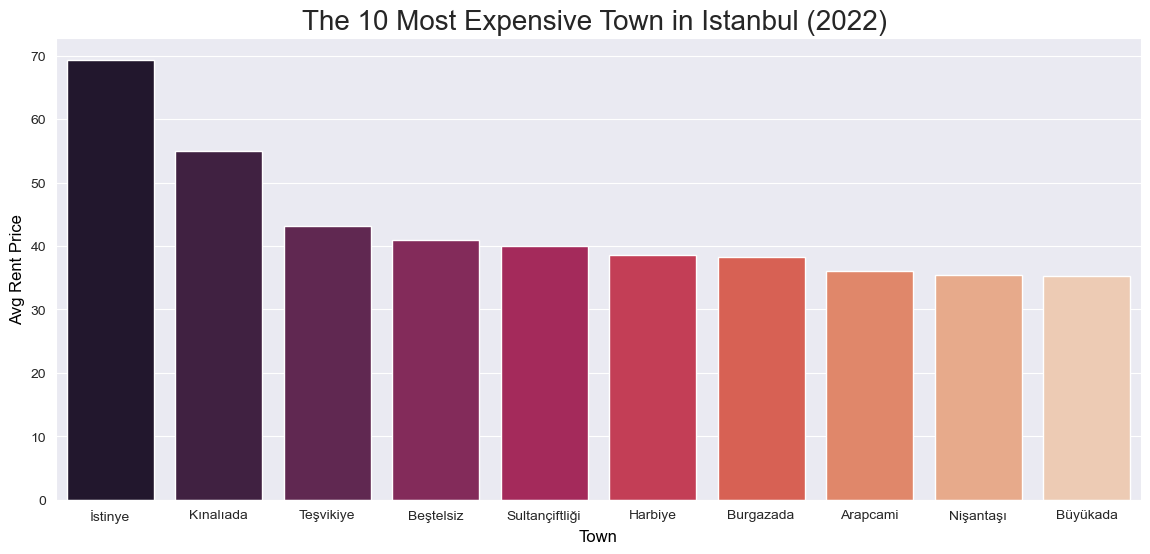

In [11]:
plt.figure(figsize=(14, 6))
sns.set_style("darkgrid")
sns.barplot(x='TOWN', y='AVG_PRICE', data=town_price_data, palette='rocket')
plt.xlabel('Town', fontsize=12, color='black')
plt.ylabel('Avg Rent Price', fontsize=12, color='black')
plt.title('The 10 Most Expensive Town in Istanbul (2022) ', fontsize=20)
plt.show()

In [12]:
query_statement2 = f"SELECT district as DISTRICT, avg(price) AS AVG_PRICE FROM RENT_HOUSE GROUP BY district HAVING avg(price) > 0 ORDER BY avg(price) desc"
query_output2 = pd.read_sql(query_statement2,conn)

district_price_data = pd.DataFrame(query_output2)
district_price_data = district_price_data.head(10)
district_price_data

,DISTRICT,AVG_PRICE
0,50. Yıl Mh.,90.636364
1,Pınar Mh.,81.018750
2,Zerzavatçı Mh.,75.000000
3,İstinye Mh.,68.219780
4,Kazlıçeşme Mh.,68.053738
5,Bülbül Mh.,61.222222
6,Kınalıada Mh.,54.952381
7,Sakızağacı Mh.,49.236275
8,Rumeli Hisarı Mh.,44.249000
9,Teşvikiye Mh.,43.214430


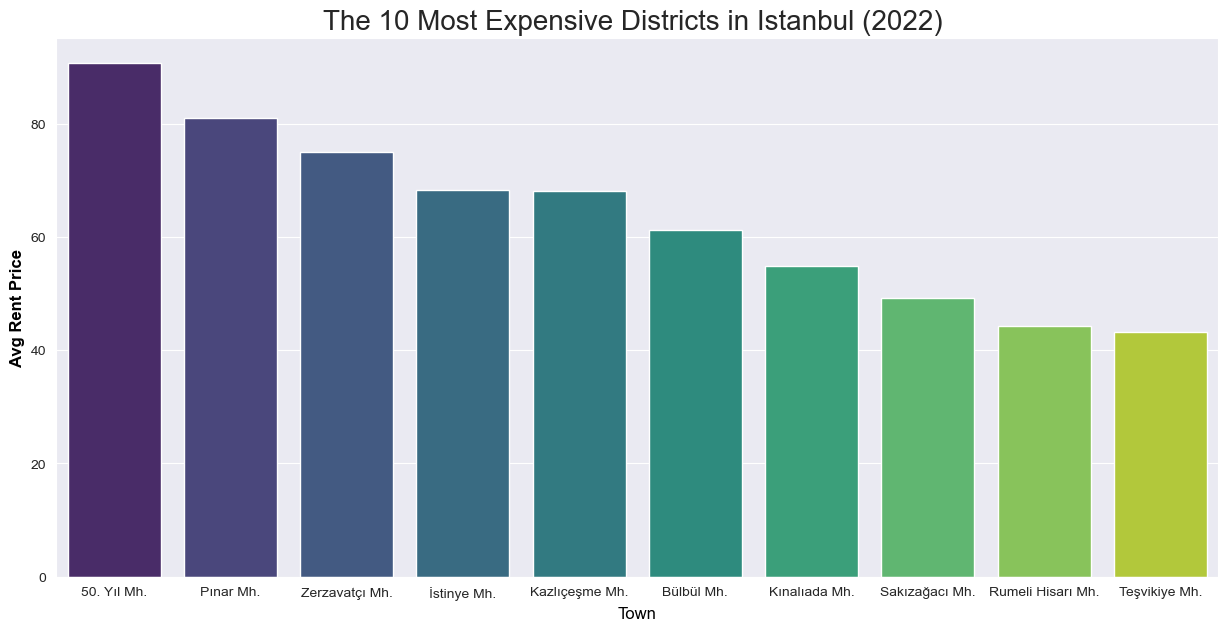

In [13]:
plt.figure(figsize=(15, 7))
sns.set_style("darkgrid")
sns.barplot(x='DISTRICT', y='AVG_PRICE', data=district_price_data, palette='viridis')
plt.xlabel('Town', fontsize=12 ,color='black')
plt.ylabel('Avg Rent Price', fontsize=12, fontweight = 'bold', color='black')
plt.title('The 10 Most Expensive Districts in Istanbul (2022) ', fontsize=20)
plt.show()

In [14]:
query_statement3 = f"""SELECT numberOfRooms as Number_of_Rooms, count(numberOfRooms) as Count, avg(price) AS AVG_PRICE FROM RENT_HOUSE 
GROUP BY numberOfRooms 
HAVING avg(price) > 0 
ORDER BY Count desc"""
query_output3 = pd.read_sql(query_statement3,conn)
conn.close()

numberOfRooms_price_data = pd.DataFrame(query_output3)
numberOfRooms_price_data = numberOfRooms_price_data.head(5)
numberOfRooms_price_data.head(5)

,Number_of_Rooms,Count,AVG_PRICE
0,2+1,10954,11.730688
1,3+1,8654,15.383331
2,1+1,5205,11.304895
3,4+1,1445,29.750918
4,1+0,1078,7.722240


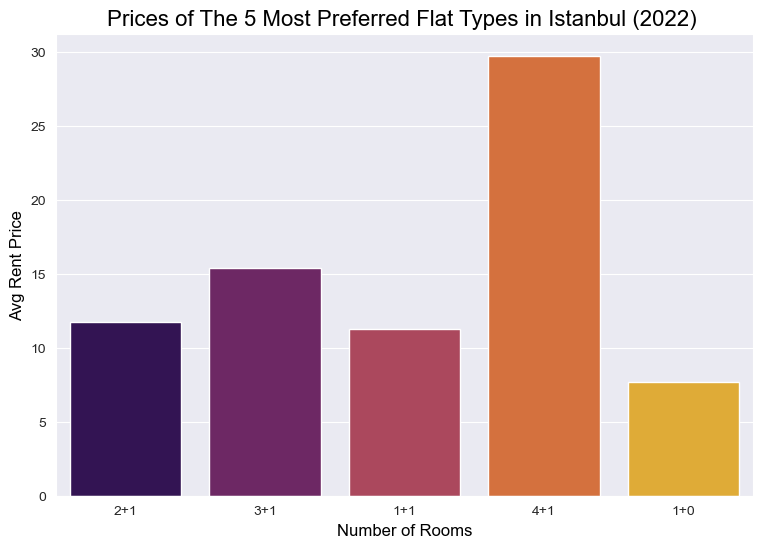

In [15]:
plt.figure(figsize=(9, 6))
sns.set_style("darkgrid")
sns.barplot(x='Number_of_Rooms', y='AVG_PRICE', data=numberOfRooms_price_data, palette='inferno')
plt.xlabel('Number of Rooms', fontsize=12, color='black')
plt.ylabel('Avg Rent Price', fontsize=12, color='black')
plt.title('Prices of The 5 Most Preferred Flat Types in Istanbul (2022) ', fontsize=16, color='black')
plt.show()

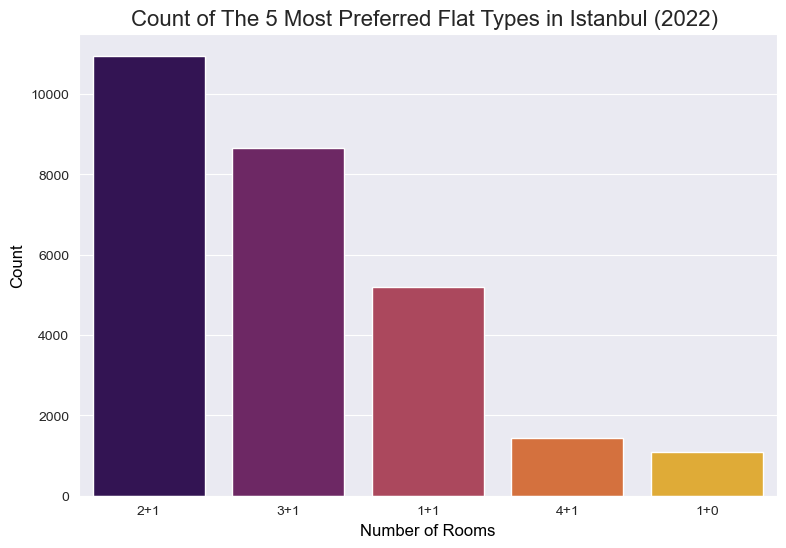

In [16]:
plt.figure(figsize=(9, 6))
sns.set_style("darkgrid")
sns.barplot(x='Number_of_Rooms', y='Count', data=numberOfRooms_price_data, palette='inferno')
plt.xlabel('Number of Rooms', fontsize=12 ,color='black')
plt.ylabel('Count', fontsize=12, color='black')
plt.title('Count of The 5 Most Preferred Flat Types in Istanbul (2022) ', fontsize=16)
plt.show()

### CONCLUSION
- The most expensive town is Istinye (AVG: 69.363 TL).
- The most expensive district is 50.Yil Mah (AVG: 90.637 TL).
- The most expensive of the most 5 preffered flat types are 4+1s (AVG: 29.751 TL).
- The most cheap of the most 5 preffered flat types are 1+0s (AVG: 7.700 TL).
- The most preferred flat types are 2+1s.